# **1. Import Library**

Mengimport library yang dibutuhkan

In [1]:
!"{sys.executable}" -m pip install matplotlib-venn

/bin/bash: line 1: {sys.executable}: command not found


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Input, Model
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import seaborn as sns
from sklearn.manifold import TSNE
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from wordcloud import WordCloud

# **2. Load Dataset**

Membaca dataset buku.

In [3]:
data = pd.read_csv('https://raw.githubusercontent.com/silviaazahro/Machine-Learning-Terapan-Part-2/refs/heads/main/dataset/dataset_buku.csv')

Menampilkan sample data

In [4]:
data.head()

,isbn13,isbn10,title,subtitle,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count
0,9780002005883,0002005883,Gilead,NaN,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0
1,9780002261982,0002261987,Spider's Web,A Novel,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0
2,9780006163831,0006163831,The One Tree,NaN,Stephen R. Donaldson,American fiction,http://books.google.com/books/content?id=OmQaw...,Volume Two of Stephen Donaldson's acclaimed se...,1982.0,3.97,479.0,172.0
3,9780006178736,0006178731,Rage of angels,NaN,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0
4,9780006280897,0006280897,The Four Loves,NaN,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,4.15,170.0,33684.0


# **3. Data Wrangling**

Mengecek apakah ada missing value

In [5]:
data.isnull().sum()

,0
isbn13,0
isbn10,0
title,0
subtitle,4429
authors,72
categories,99
thumbnail,329
description,262
published_year,6
average_rating,43


Masih terdapat Missing Value, maka kita perlu menghilangkan Missing Value pada kolom **subtitle, authors, categories, thumbnail, description, description, published_year, average_rating, num_pages, ratings_count** dengan menggunakan imputas Mean dan Median.

In [6]:
data['subtitle'] = data['subtitle'].fillna('')
data['authors'] = data['authors'].fillna('Unknown')
data['categories'] = data['categories'].fillna('Other')
data['thumbnail'] = data['thumbnail'].fillna('https://example.com/default-thumbnail.jpg')
data['description'] = data['description'].fillna('No description available')
data['published_year'] = data['published_year'].fillna(data['published_year'].median())
data['average_rating'] = data['average_rating'].fillna(data['average_rating'].mean())
data['num_pages'] = data['num_pages'].fillna(data['num_pages'].median())
data['ratings_count'] = data['ratings_count'].fillna(0)

Mengecek kembali apakah masih terdapat Missing Value atau tidak

In [7]:
data.isnull().sum()

,0
isbn13,0
isbn10,0
title,0
subtitle,0
authors,0
categories,0
thumbnail,0
description,0
published_year,0
average_rating,0


# **4. EDA**

Melihat distribusi data pada fitur rating

<ipython-input-8-9b5b8ff0d607>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='average_rating', data=data, palette='viridis')


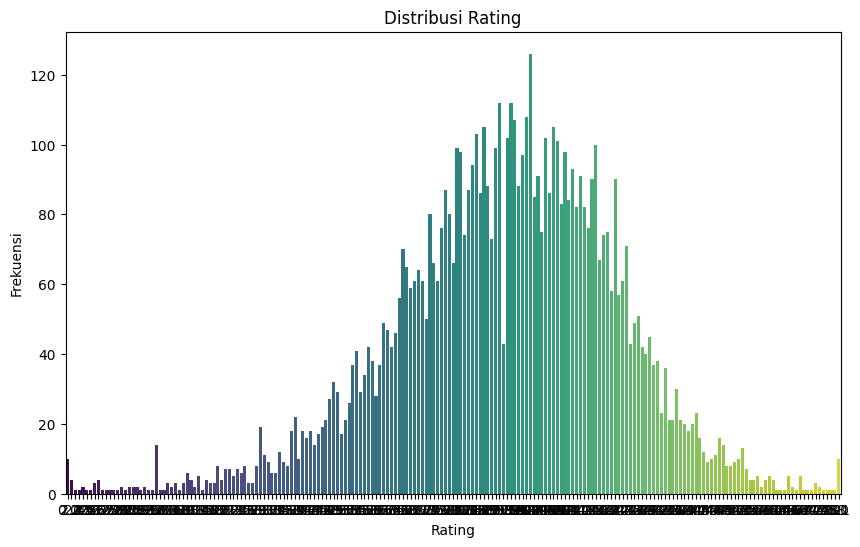

In [8]:
plt.figure(figsize=(10, 6))
sns.countplot(x='average_rating', data=data, palette='viridis')
plt.title('Distribusi Rating')
plt.xlabel('Rating')
plt.ylabel('Frekuensi')
plt.show()

Melihat histogram dari fitur rating

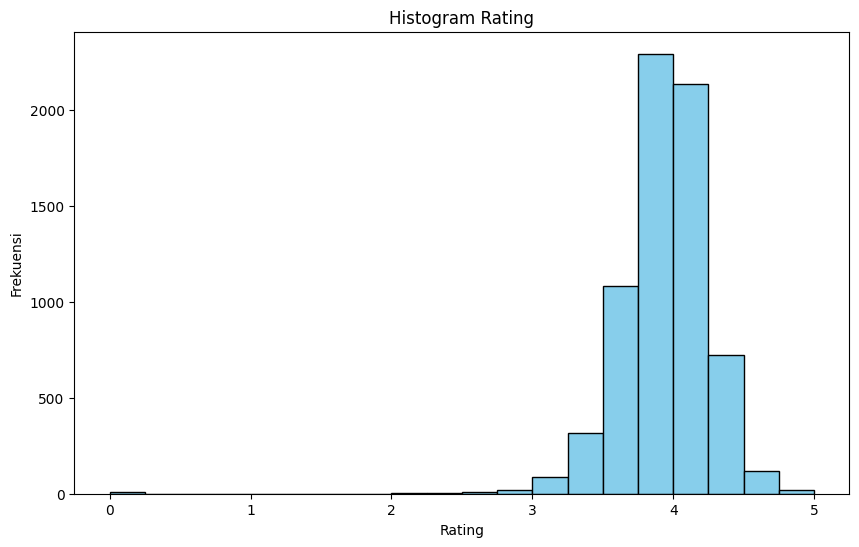

In [9]:
plt.figure(figsize=(10, 6))
plt.hist(data['average_rating'], bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram Rating')
plt.xlabel('Rating')
plt.ylabel('Frekuensi')
plt.show()

Memvisualisasi fitur rating dengan boxplot untuk melihat korelasi atau insight lain.

<ipython-input-10-482405742210>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='average_rating', data=data, palette='viridis')


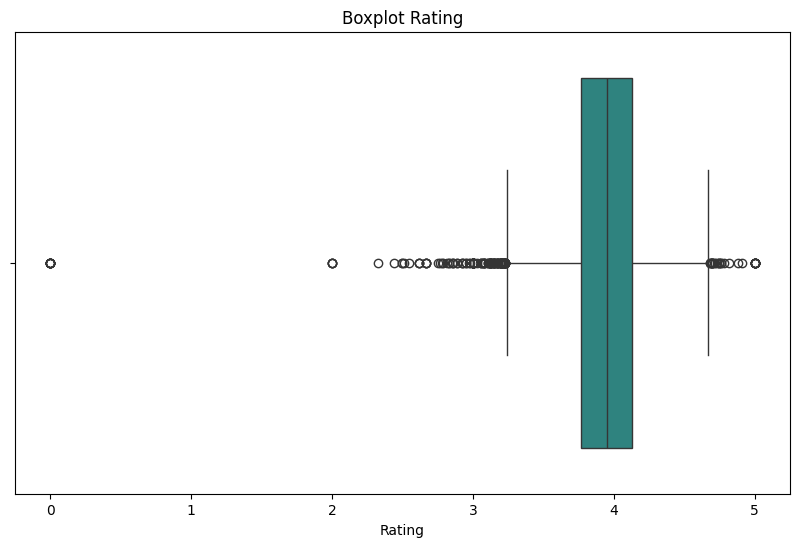

In [10]:
plt.figure(figsize=(10,6))
sns.boxplot(x='average_rating', data=data, palette='viridis')
plt.title('Boxplot Rating')
plt.xlabel('Rating')
plt.show()

# **4. Data Preparation**

Mengambil daftar unik tahun publish dan jumlah halaman

In [11]:
# Ambil nilai unik dari dataset
unique_year = data['published_year'].unique().tolist()
unique_pages = data['num_pages'].unique().tolist()

Membuat dictionary untuk mapping published_year dan num_pages ke integer

In [12]:
# Buat mapping dari nilai asli ke indeks
year_to_index = {year: idx for idx, year in enumerate(sorted(unique_year))}
pages_to_index = {pages: idx for idx, pages in enumerate(sorted(unique_pages))}

# Buat mapping dari indeks ke nilai asli
index_to_year = {idx: year for year, idx in year_to_index.items()}
index_to_pages = {idx: pages for pages, idx in pages_to_index.items()}

Mapping ke dataframe

In [13]:
# Mapping kolom ke indeks di DataFrame
data['year_index'] = data['published_year'].map(year_to_index)
data['pages_index'] = data['num_pages'].map(pages_to_index)

Mengambil nilai min dan max dari rating

In [14]:
min_rating = data['average_rating'].min()
max_rating = data['average_rating'].max()

Normalisasi rating ke skala 0-1

In [15]:
data['rating_norm'] = data['average_rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating))

Mendeklarasikan kolom fitur dan target

In [16]:
# Input: kolom 'published_year' dan 'num_pages'
x = data[['year_index', 'pages_index']].values

# Target: rating yang sudah dinormalisasi
y = data['rating_norm'].values

# **5. Data Splitting**

Mengacak data

In [17]:
data = data.sample(frac=1, random_state=42)
x = data[['year_index', 'pages_index']].values
y = data['rating_norm'].values

Membagi ke training dan validasi


In [18]:
train_size = int(0.8 * len(data))
x_train, x_val = x[:train_size], x[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

print("Jumlah data training:", x_train.shape[0])
print("Jumlah data validasi:", x_val.shape[0])

Jumlah data training: 5448
Jumlah data validasi: 1362


# **6. Model Building**

## 6.1. RecommenderNet

Melakukan model building dengan RecommenderNet dan Mengkompilasi model dengan Binary Crossentropy dan menggunakan optimizer Adam serta metric RMSE.

In [19]:
class RecommenderNet(tf.keras.Model):
    def __init__(self, num_year, num_pages, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_year = num_year
        self.num_pages = num_pages
        self.embedding_size = embedding_size

        # Embedding untuk year
        self.year_embedding = layers.Embedding(
            num_year,
            embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=keras.regularizers.l2(1e-6)
        )
        self.year_bias = layers.Embedding(num_year, 1)

        # Embedding untuk pages
        self.pages_embedding = layers.Embedding(
            num_pages,
            embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=keras.regularizers.l2(1e-6)
        )
        self.pages_bias = layers.Embedding(num_pages, 1)

    def call(self, inputs):
        year_vector = self.year_embedding(inputs[:, 0])
        year_bias = self.year_bias(inputs[:, 0])
        pages_vector = self.pages_embedding(inputs[:, 1])
        pages_bias = self.pages_bias(inputs[:, 1])

        # Dot product antara year dan pages embedding
        dot_year_pages = tf.reduce_sum(year_vector * pages_vector, axis=1, keepdims=True)

        # Menambahkan bias
        x = dot_year_pages + year_bias + pages_bias

        # Aktivasi sigmoid untuk output antara 0 dan 1
        return tf.nn.sigmoid(x)

num_year = len(year_to_index)
num_pages = len(pages_to_index)
embedding_size = 20

model = RecommenderNet(
    num_year,
    num_pages,
    embedding_size
)

model.compile(
    loss='mean_squared_error',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

## 6.2. NeuMF

In [20]:
from tensorflow.keras import Input, Model, layers
import tensorflow as tf

def get_NeuMF_model(num_years, num_pages, mf_dim=8, mlp_layers=[64,32,16,8], dropout=0.0):
    # Input layer
    year_input = Input(shape=(1,), name="year_input")
    page_input = Input(shape=(1,), name="page_input")

    # MF part embedding
    mf_year_embedding = layers.Embedding(num_years, mf_dim, name="mf_year_embedding")(year_input)
    mf_page_embedding = layers.Embedding(num_pages, mf_dim, name="mf_page_embedding")(page_input)
    mf_year_embedding = layers.Flatten()(mf_year_embedding)
    mf_page_embedding = layers.Flatten()(mf_page_embedding)
    mf_vector = layers.multiply([mf_year_embedding, mf_page_embedding])

    # MLP part embedding
    mlp_embedding_dim = mlp_layers[0] // 2
    mlp_year_embedding = layers.Embedding(num_years, mlp_embedding_dim, name="mlp_year_embedding")(year_input)
    mlp_page_embedding = layers.Embedding(num_pages, mlp_embedding_dim, name="mlp_page_embedding")(page_input)
    mlp_year_embedding = layers.Flatten()(mlp_year_embedding)
    mlp_page_embedding = layers.Flatten()(mlp_page_embedding)
    mlp_vector = layers.concatenate([mlp_year_embedding, mlp_page_embedding])

    # MLP layers
    for idx, units in enumerate(mlp_layers[1:]):
        mlp_vector = layers.Dense(units, activation='relu', name=f"mlp_dense_{idx}")(mlp_vector)
        if dropout > 0:
            mlp_vector = layers.Dropout(dropout)(mlp_vector)

    # Concatenate MF and MLP parts
    neumf_vector = layers.concatenate([mf_vector, mlp_vector])

    # Final prediction layer
    prediction = layers.Dense(1, activation="sigmoid", name="prediction")(neumf_vector)

    model = Model(inputs=[year_input, page_input], outputs=prediction)
    return model

# Inisialisasi NeuMF:
num_years = len(year_to_index)
num_pages = len(pages_to_index)

neuMF_model = get_NeuMF_model(
    num_years, num_pages,
    mf_dim=8,
    mlp_layers=[64,32,16,8]
)

neuMF_model.compile(
    loss='mean_squared_error',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

# **7. Model Training**

Menerapkan Callbacks early stoping untuk menghentikan model ketika val_loss tidak berkurang selama 3 epoch dan merestore kembali weight yang terbaik.

In [21]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=1e-6,
        verbose=1
    )
]

## 7.1. RecommenderNet

Melatih model RecommenderNet.

In [22]:
history = model.fit(
    x_train, y_train,
    batch_size=32,
    epochs=20,
    validation_data=(x_val, y_val),
    callbacks=callbacks
)

Epoch 1/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0788 - root_mean_squared_error: 0.2805 - val_loss: 0.0548 - val_root_mean_squared_error: 0.2340 - learning_rate: 0.0010
Epoch 2/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0476 - root_mean_squared_error: 0.2179 - val_loss: 0.0337 - val_root_mean_squared_error: 0.1835 - learning_rate: 0.0010
Epoch 3/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0272 - root_mean_squared_error: 0.1645 - val_loss: 0.0218 - val_root_mean_squared_error: 0.1473 - learning_rate: 0.0010
Epoch 4/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0157 - root_mean_squared_error: 0.1249 - val_loss: 0.0161 - val_root_mean_squared_error: 0.1262 - learning_rate: 0.0010
Epoch 5/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0118 - root_mean_squared_error: 0.1079 - val_loss: 0.0132 - val_root_mean_squared_error: 0.1140 - learning_rate: 0.0010
Epoch 6/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0088 - root_mean_squared_err

## 7.2. NeuMF

Melatih model NeuMF.

In [23]:
history_neuMF = neuMF_model.fit(
    [x_train[:,0], x_train[:,1]], y_train,
    batch_size=32,
    epochs=20,
    validation_data=([x_val[:,0], x_val[:,1]], y_val),
    callbacks=callbacks
    )

Epoch 1/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0447 - root_mean_squared_error: 0.2061 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0714 - learning_rate: 0.0010
Epoch 2/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0047 - root_mean_squared_error: 0.0683 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0695 - learning_rate: 0.0010
Epoch 3/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0039 - root_mean_squared_error: 0.0626 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0704 - learning_rate: 0.0010
Epoch 4/20
162/171 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038 - root_mean_squared_error: 0.0616
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0038 - root_mean_squared_error: 0.0616 - val_loss: 0.0049 - val_root_mean_squared_error: 0.0701 - learning_rate: 0.0010
Epoch 5/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0035 - root_mean_squared_error: 0.0590 - val

# **8. Model Evaluation**

## 8.1. Plot History Training

Membandingkan dua model rekomendasi, RecommenderNet dan NeuMF, dengan menampilkan grafik yang menunjukkan bagaimana loss dan RMSE berubah selama pelatihan.

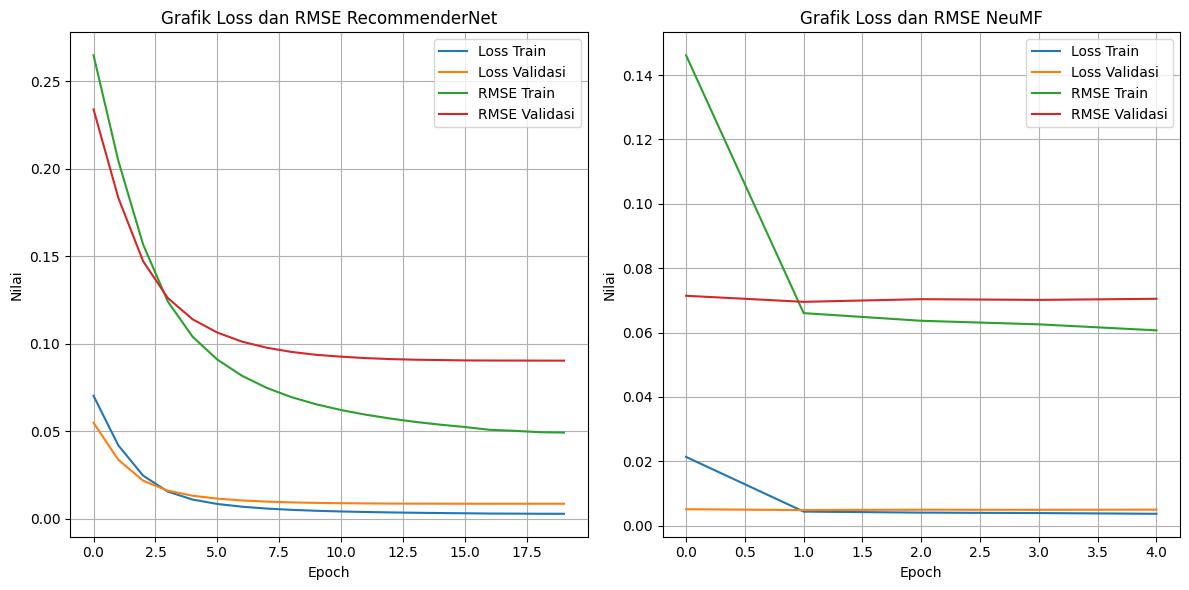

In [24]:
# Membuat figure dan axes untuk dua plot berdampingan
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot pertama (RecommenderNet)
ax1.plot(history.history['loss'], label='Loss Train')
ax1.plot(history.history['val_loss'], label='Loss Validasi')
ax1.plot(history.history['root_mean_squared_error'], label='RMSE Train')
ax1.plot(history.history['val_root_mean_squared_error'], label='RMSE Validasi')
ax1.set_title('Grafik Loss dan RMSE RecommenderNet')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Nilai')
ax1.legend()
ax1.grid(True)

# Plot kedua (NeuMF)
ax2.plot(history_neuMF.history['loss'], label='Loss Train')
ax2.plot(history_neuMF.history['val_loss'], label='Loss Validasi')
ax2.plot(history_neuMF.history['root_mean_squared_error'], label='RMSE Train')
ax2.plot(history_neuMF.history['val_root_mean_squared_error'], label='RMSE Validasi')
ax2.set_title('Grafik Loss dan RMSE NeuMF')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Nilai')
ax2.legend()
ax2.grid(True)

# Menampilkan plot
plt.tight_layout()
plt.show()

## 8.2. Metrik Error (RMSE, MAE, R²)

Membandingkan kinerja dua model rekomendasi, RecommenderNet dan NeuMF, dengan menghitung beberapa metrik evaluasi seperti RMSE, MAE, dan R².

In [25]:
# Prediksi dan rescaling untuk model RecommenderNet
y_pred = model.predict(x_val).flatten()
y_pred_rescaled = y_pred * (max_rating - min_rating) + min_rating
y_val_rescaled = y_val * (max_rating - min_rating) + min_rating

mse_recommender = mean_squared_error(y_val_rescaled, y_pred_rescaled)
rmse_recommender = np.sqrt(mse_recommender)
mae_recommender = mean_absolute_error(y_val_rescaled, y_pred_rescaled)
r2_recommender = r2_score(y_val_rescaled, y_pred_rescaled)

# Prediksi dan rescaling untuk model NeuMF
year_input = x_val[:, 0]
pages_input = x_val[:, 1]
y_pred_neuMF = neuMF_model.predict([year_input, pages_input]).flatten()

y_pred_rescaled_neuMF = y_pred_neuMF * (max_rating - min_rating) + min_rating
y_val_rescaled_neuMF = y_val * (max_rating - min_rating) + min_rating

mse_neuMF = mean_squared_error(y_val_rescaled_neuMF, y_pred_rescaled_neuMF)
rmse_neuMF = np.sqrt(mse_neuMF)
mae_neuMF = mean_absolute_error(y_val_rescaled_neuMF, y_pred_rescaled_neuMF)
r2_neuMF = r2_score(y_val_rescaled_neuMF, y_pred_rescaled_neuMF)

# Membuat DataFrame untuk perbandingan
comparison_df = pd.DataFrame({
    "Metric": ["RMSE", "MAE", "R²"],
    "RecommenderNet": [rmse_recommender, mae_recommender, r2_recommender],
    "NeuMF": [rmse_neuMF, mae_neuMF, r2_neuMF]
})

comparison_df


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


,Metric,RecommenderNet,NeuMF
0,RMSE,0.451972,0.347660
1,MAE,0.321449,0.242809
2,R²,-0.766955,-0.045472


## 8.3. Scatterplot : Actual Rating vs Predicted Rating

Membandingkan hasil prediksi rating dari dua model rekomendasi, RecommenderNet dan NeuMF, dengan menggunakan scatter plot. Garis merah pada kedua plot menunjukkan garis referensi di mana prediksi dan rating sebenarnya akan saling bertemu. Hal ini dapat membantu melihat seberapa akurat prediksi masing-masing model dibandingkan dengan rating yang sebenarnya.

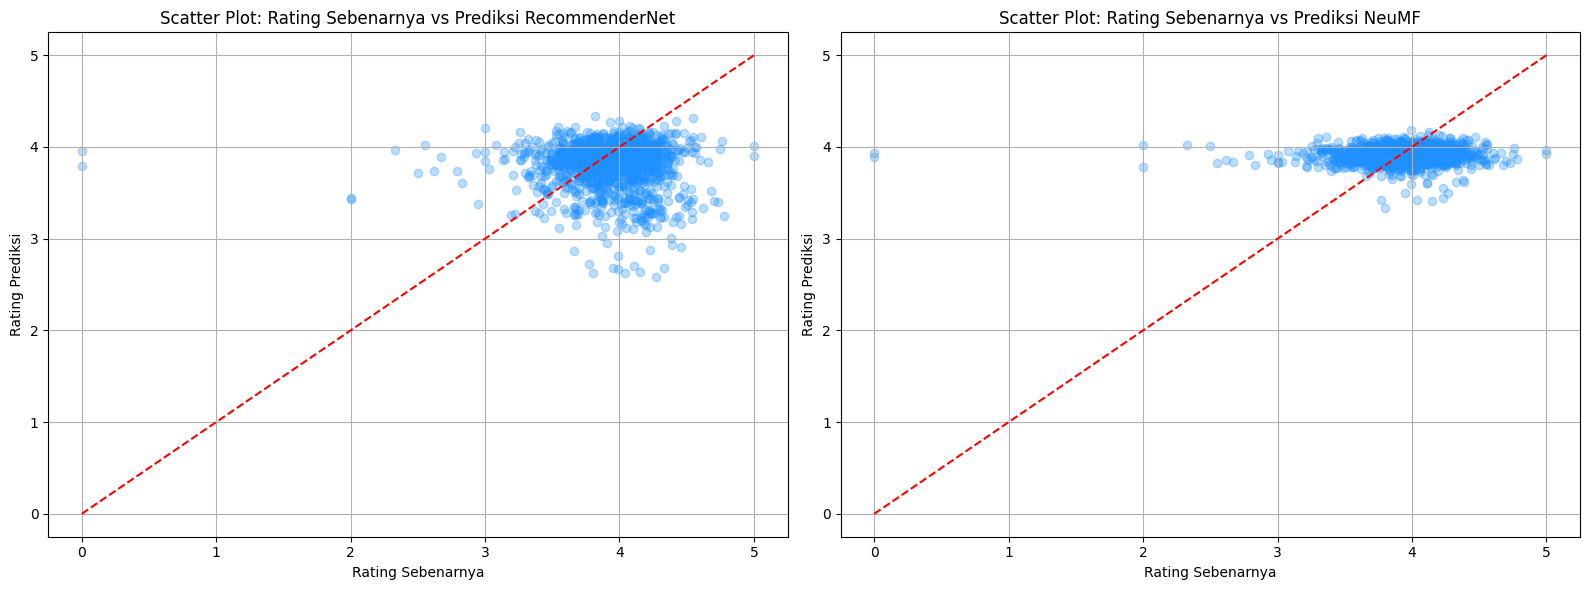

In [26]:
# Membuat figure dan axes untuk dua scatter plot berdampingan
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot pertama (RecommenderNet)
ax1.scatter(y_val_rescaled, y_pred_rescaled, alpha=0.3, color='dodgerblue')
ax1.plot([min_rating, max_rating], [min_rating, max_rating], color='red', linestyle='--')
ax1.set_xlabel('Rating Sebenarnya')
ax1.set_ylabel('Rating Prediksi')
ax1.set_title('Scatter Plot: Rating Sebenarnya vs Prediksi RecommenderNet')
ax1.grid(True)

# Plot kedua (NeuMF)
ax2.scatter(y_val_rescaled_neuMF, y_pred_rescaled_neuMF, alpha=0.3, color='dodgerblue')
ax2.plot([min_rating, max_rating], [min_rating, max_rating], color='red', linestyle='--')
ax2.set_xlabel('Rating Sebenarnya')
ax2.set_ylabel('Rating Prediksi')
ax2.set_title('Scatter Plot: Rating Sebenarnya vs Prediksi NeuMF')
ax2.grid(True)

# Menampilkan plot
plt.tight_layout()
plt.show()

## 8.4. Top-N

Membandingkan rekomendasi buku dari dua model, RecommenderNet dan NeuMF, berdasarkan prediksi yang dihasilkan oleh masing-masing model.

In [27]:
# Fungsi untuk mendapatkan rekomendasi Top-N
def get_top_n_recommendations(year_id_asli, model, n=10, use_neumf=False):
    if year_id_asli not in year_to_index:
        raise ValueError(f"Tahun {year_id_asli} tidak ditemukan dalam data. Coba salah satu dari: {list(year_to_index.keys())[:5]}...")

    year_index = year_to_index[year_id_asli]
    all_pages_indices = np.array(list(index_to_pages.keys()))

    books_in_year_pages = data[data['published_year'] == year_id_asli]['num_pages'].tolist()
    readed_indices = [pages_to_index[page] for page in books_in_year_pages if page in pages_to_index]
    unreaded_indices = list(set(all_pages_indices) - set(readed_indices))

    # Membuat input untuk model
    year_input = np.full(len(unreaded_indices), year_index)
    pages_input_for_prediction = np.array(unreaded_indices)
    if use_neumf:
        predictions = model.predict([year_input, pages_input_for_prediction], verbose=0).flatten()
    else:
        input_pairs = np.stack((year_input, pages_input_for_prediction), axis=1)
        predictions = model.predict(input_pairs, verbose=0).flatten()


    top_prediction_indices_in_unreaded = np.argsort(predictions)[-n:][::-1]
    top_books_indices_from_unreaded = pages_input_for_prediction[top_prediction_indices_in_unreaded]
    top_books_pages = [index_to_pages[idx] for idx in top_books_indices_from_unreaded]
    top_predictions = predictions[top_prediction_indices_in_unreaded]

    recommended_data = []
    for i, page_index in enumerate(top_books_indices_from_unreaded):
        page_value = index_to_pages[page_index]
        book_info = data[data['num_pages'] == page_value].iloc[0]
        recommended_data.append({
            "pages_index": page_index,
            "Predicted Score": top_predictions[i],
            "title": book_info['title'],
            "published_year": book_info['published_year'],
            "num_pages": book_info['num_pages']
        })

    top_books_df = pd.DataFrame(recommended_data)

    # Rescale the predicted score to the original rating range
    top_books_df["Predicted Rating"] = top_books_df["Predicted Score"] * (max_rating - min_rating) + min_rating

    # Sort and add rank
    top_books_df = top_books_df.sort_values(by="Predicted Score", ascending=False).reset_index(drop=True)
    top_books_df["Rank"] = range(1, len(top_books_df) + 1)

    # Select the final columns
    return top_books_df[["Rank", "title", "Predicted Score", "Predicted Rating", "published_year", "num_pages"]]

# Pemanggilan untuk mengambil rekomendasi top-10 dari model pertama
top_n_rec_recommender = get_top_n_recommendations(2010, model, n=10, use_neumf=False)

# Pemanggilan untuk mengambil rekomendasi top-10 dari model kedua (NeuMF)
top_n_rec_neumf = get_top_n_recommendations(2010, neuMF_model, n=10, use_neumf=True)

# Gabungkan hasil dari kedua model
top_n_rec_recommender['Model'] = 'RecommenderNet'
top_n_rec_neumf['Model'] = 'NeuMF'

# Gabungkan hasil kedua DataFrame tanpa menduplikasi data
top_n_combined = pd.concat([top_n_rec_recommender, top_n_rec_neumf], ignore_index=True)

# Menampilkan hasil
top_n_combined

,Rank,title,Predicted Score,Predicted Rating,published_year,num_pages,Model
0,1,Rain of Gold,0.749532,3.747658,1992.0,576.0,RecommenderNet
1,2,The Tiny One,0.718907,3.594535,2000.0,258.0,RecommenderNet
2,3,Tsubasa,0.714624,3.573122,2005.0,194.0,RecommenderNet
3,4,"The Civil War, a Narrative",0.713709,3.568545,1986.0,2965.0,RecommenderNet
4,5,Weetzie Bat,0.711807,3.559034,2004.0,128.0,RecommenderNet
5,6,Angel Christmas,0.710767,3.553837,1995.0,384.0,RecommenderNet
6,7,Something Under the Bed is Drooling,0.707938,3.539690,1988.0,127.0,RecommenderNet
7,8,Kaddish and Other Poems: 1958-1960,0.707410,3.537052,1961.0,99.0,RecommenderNet
8,9,The Picture of Dorian Gray,0.706687,3.533435,1998.0,367.0,RecommenderNet
9,10,Walt Whitman's America,0.706406,3.532029,1996.0,672.0,RecommenderNet


Membandingkan rekomendasi buku dari dua model, RecommenderNet dan NeuMF, dalam bentuk grafik horizontal yang menampilkan skor prediksi dari setiap buku yang direkomendasikan oleh kedua model.

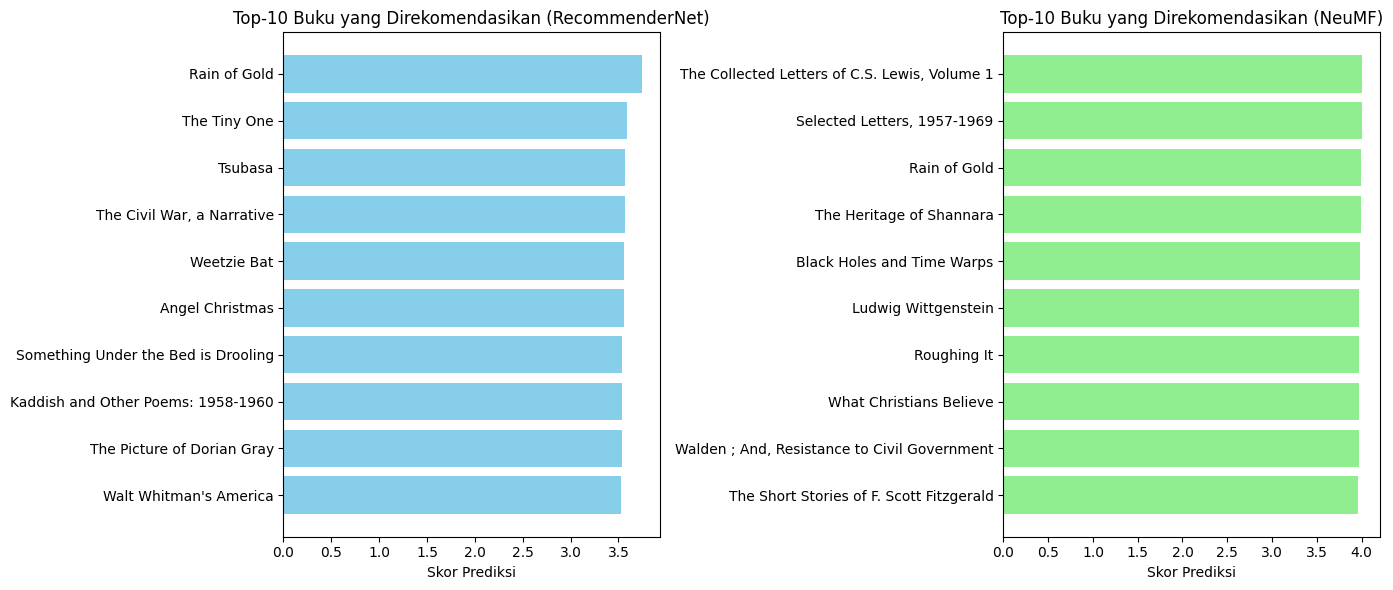

In [28]:
import matplotlib.pyplot as plt

# Ambil skor dari hasil DataFrame untuk RecommenderNet
top_scores_recommender = top_n_rec_recommender['Predicted Rating'].values
top_titles_recommender = top_n_rec_recommender['title'].values

# Ambil skor dari hasil DataFrame untuk NeuMF
top_scores_neumf = top_n_rec_neumf['Predicted Rating'].values
top_titles_neumf = top_n_rec_neumf['title'].values

# Membuat sub-plot untuk perbandingan
plt.figure(figsize=(14, 6))

# Plot Top-10 rekomendasi RecommenderNet
plt.subplot(1, 2, 1)
plt.barh(top_titles_recommender, top_scores_recommender, color='skyblue')
plt.xlabel('Skor Prediksi')
plt.title('Top-10 Buku yang Direkomendasikan (RecommenderNet)')
plt.gca().invert_yaxis()

# Plot Top-10 rekomendasi NeuMF
plt.subplot(1, 2, 2)
plt.barh(top_titles_neumf, top_scores_neumf, color='lightgreen')
plt.xlabel('Skor Prediksi')
plt.title('Top-10 Buku yang Direkomendasikan (NeuMF)')
plt.gca().invert_yaxis()

# Menampilkan kedua plot
plt.tight_layout()
plt.show()

## 8.5. Visualisasi 2D Embedding

Membandingkan embedding buku yang dihasilkan oleh dua model rekomendasi, RecommenderNet dan NeuMF, dengan memvisualisasikan hasil reduksi dimensi menggunakan t-SNE.

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


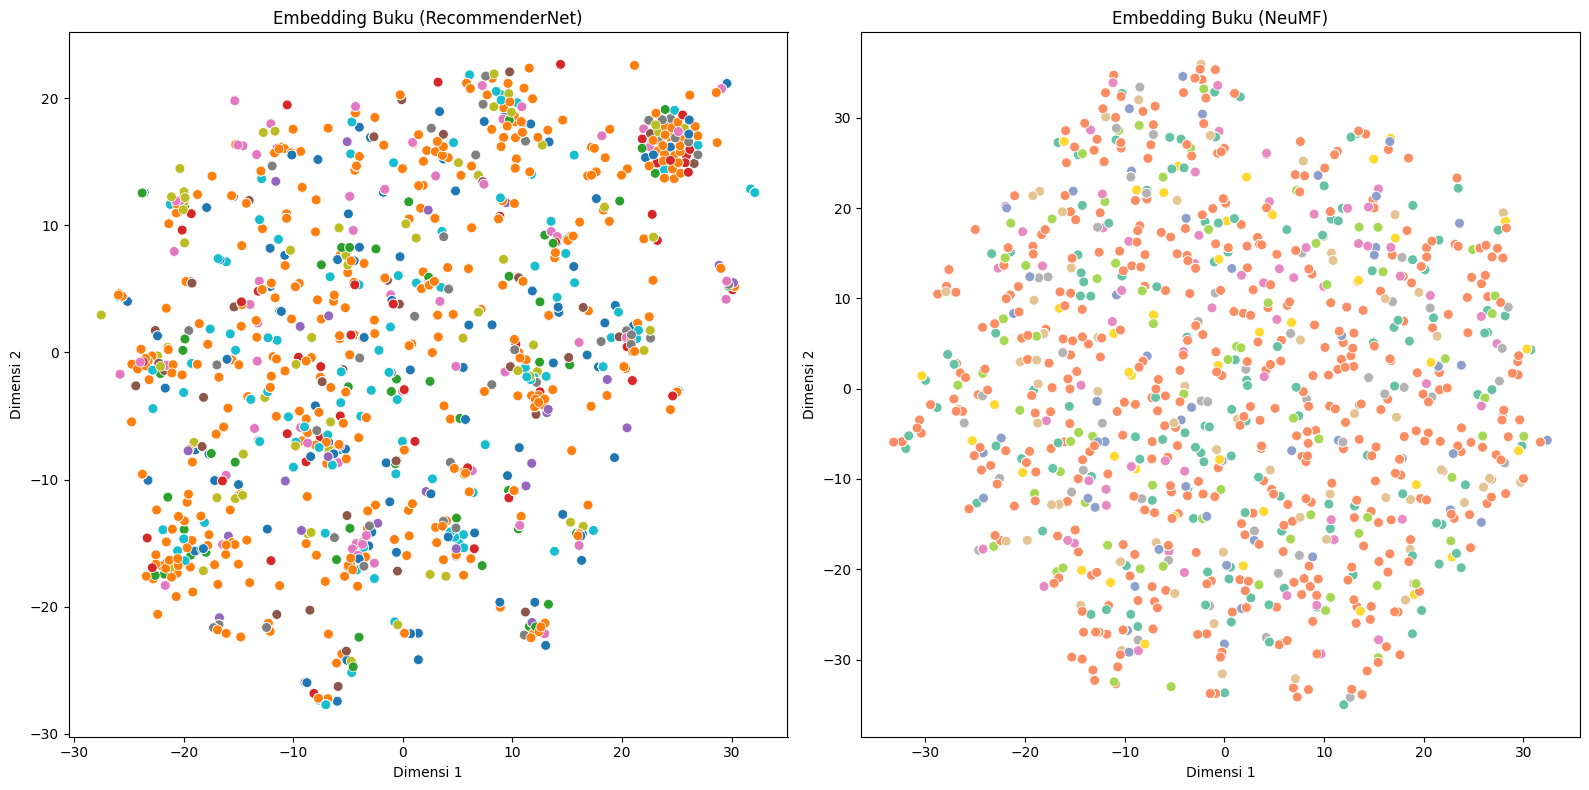

In [29]:
# Mengambil matriks embedding dari model pertama (RecommenderNet)
books_embeddings_recommender = model.pages_embedding.get_weights()[0]  # bentuk: (num_pages, embedding_size)

# Reduksi dimensi ke 2D dengan t-SNE untuk model pertama
tsne_recommender = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
books_embeddings_2d_recommender = tsne_recommender.fit_transform(books_embeddings_recommender)

# DataFrame untuk plot model pertama
df_emb_recommender = pd.DataFrame(books_embeddings_2d_recommender, columns=['x', 'y'])
df_emb_recommender['pages_index'] = np.arange(books_embeddings_recommender.shape[0])

# Mengambil matriks embedding dari model kedua (NeuMF)
books_embedding_layer_neumf = neuMF_model.get_layer("mf_page_embedding")
books_embeddings_neumf = books_embedding_layer_neumf.get_weights()[0]

# Reduksi dimensi ke 2D dengan t-SNE untuk model kedua
tsne_neumf = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
books_embeddings_2d_neumf = tsne_neumf.fit_transform(books_embeddings_neumf)

# DataFrame untuk plot model kedua
df_emb_neumf = pd.DataFrame(books_embeddings_2d_neumf, columns=['x', 'y'])
df_emb_neumf['pages_index'] = np.arange(books_embeddings_neumf.shape[0])

# Membaca data
data['pages_index'] = data['num_pages'].map(pages_to_index)

# Menggabungkan data embedding dengan pages info untuk kedua model
df_plot_recommender = pd.merge(df_emb_recommender, data, on='pages_index', how='left')
df_plot_neumf = pd.merge(df_emb_neumf, data, on='pages_index', how='left')

# Membuat figure untuk visualisasi gabungan
plt.figure(figsize=(16, 8))

# Plot untuk model pertama (RecommenderNet) di subplot kiri
plt.subplot(1, 2, 1)
sns.scatterplot(data=df_plot_recommender, x='x', y='y', hue='categories', palette='tab10', legend=False, s=50)
plt.title('Embedding Buku (RecommenderNet)')
plt.xlabel('Dimensi 1')
plt.ylabel('Dimensi 2')

# Plot untuk model kedua (NeuMF) di subplot kanan
plt.subplot(1, 2, 2)
sns.scatterplot(data=df_plot_neumf, x='x', y='y', hue='categories', palette='Set2', legend=False, s=50)
plt.title('Embedding Buku (NeuMF)')
plt.xlabel('Dimensi 1')
plt.ylabel('Dimensi 2')

# Menampilkan plot
plt.tight_layout()
plt.show()

## 8.6. Venn Diagram

Membandingkan hasil rekomendasi dari dua model, RecommenderNet dan NeuMF, dengan menggunakan Diagram Venn.

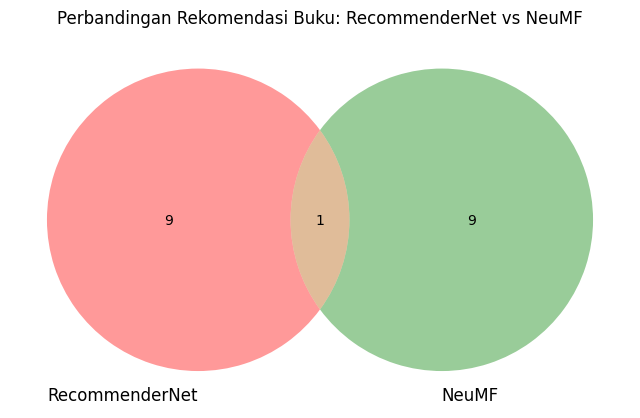

In [30]:
# Ambil Top-10 rekomendasi dari model pertama (RecommenderNet)
top_n_rec_recommender = get_top_n_recommendations(2012, model, n=10, use_neumf=False)
recommended_books_recommender = set(top_n_rec_recommender['title'])

# Ambil Top-10 rekomendasi dari model kedua (NeuMF)
top_n_rec_neumf = get_top_n_recommendations(2012, neuMF_model, n=10, use_neumf=True)
recommended_books_neumf = set(top_n_rec_neumf['title'])

# Membuat Diagram Venn untuk membandingkan rekomendasi kedua model
plt.figure(figsize=(8, 6))
venn2([recommended_books_recommender, recommended_books_neumf],
      set_labels=('RecommenderNet', 'NeuMF'))

plt.title('Perbandingan Rekomendasi Buku: RecommenderNet vs NeuMF')
plt.show()

## 8.7. WordCloud

Visualisasi WordCloud yang membandingkan judul buku yang direkomendasikan oleh dua model, RecommenderNet dan NeuMF.

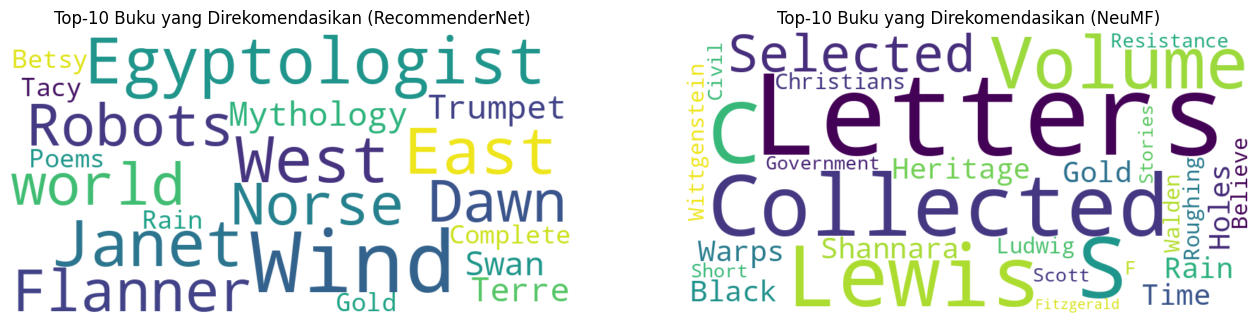

In [31]:
# Gabungkan judul buku yang direkomendasikan dari model pertama (RecommenderNet)
top_titles_recommender = top_n_rec_recommender['title'].values
text_recommender = " ".join(top_titles_recommender)

# Buat word cloud untuk model pertama (RecommenderNet)
wordcloud_recommender = WordCloud(width=800, height=400, background_color='white').generate(text_recommender)

# Gabungkan judul buku yang direkomendasikan dari model kedua (NeuMF)
top_titles_neumf = top_n_rec_neumf['title'].values
text_neumf = " ".join(top_titles_neumf)

# Buat word cloud untuk model kedua (NeuMF)
wordcloud_neumf = WordCloud(width=800, height=400, background_color='white').generate(text_neumf)

# Membuat figure untuk visualisasi gabungan
plt.figure(figsize=(16, 8))

# Plot WordCloud untuk model pertama (RecommenderNet) di sebelah kiri
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_recommender, interpolation='bilinear')
plt.axis('off')
plt.title('Top-10 Buku yang Direkomendasikan (RecommenderNet)')

# Plot WordCloud untuk model kedua (NeuMF) di sebelah kanan
plt.subplot(1, 2, 2)
plt.imshow(wordcloud_neumf, interpolation='bilinear')
plt.axis('off')
plt.title('Top-10 Buku yang Direkomendasikan (NeuMF)')

# Menampilkan plot
plt.show()